In [1]:
"""
Created on Sun Mar 15 00:33:42 2020
Objective: 
Predict the total number of active users (guest-users and registered-users) to help with demand forcasting.
@author: dexterch
"""
#Phase 1: Importing Data
from datetime import datetime
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns 
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv("../AIAP 2020/scooter_rental_data.csv")
display(df.head())
df1 = df[df.isna().any(axis=1)] #display any single example with missing values (NA)
display (df1) #shows all data is has no NA.
display (df.columns, df.shape, df.index)
df.columns=[x.replace('-','_') for x in df.columns] #make all 'space' to '_'
df.columns=[x.lower() for x in df.columns] #make all lower case
display(df.head())

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,-2,10


,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users


Index(['date', 'hr', 'weather', 'temperature', 'feels-like-temperature',
       'relative-humidity', 'windspeed', 'psi', 'guest-users',
       'registered-users'],
      dtype='object')

(17958, 10)

RangeIndex(start=0, stop=17958, step=1)

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_users,registered_users
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,-2,10


In [2]:
for col in df: #display all unique variables in the column
    display(df[col].unique())
for col in df: #count the number of NaN
    display(df[col].isnull().sum())

#Phase 2A: Cleaning Data (Weather)
display (df.weather.unique())
#df.loc[df['weather'] == 'lear']
df["weather"]= df["weather"].str.lower()  #replace all lower letters
display (df.weather.unique())
df["weather"].replace({'lear':'clear'}, inplace=True)
df["weather"].replace({'loudy':'cloudy'}, inplace=True)
display (df.weather.unique())

display(df.head())
#Phase 2B: Cleaning Data (Date)
for col in df[["hr","temperature","feels_like_temperature","relative_humidity","windspeed","psi","guest_users","registered_users"]]: #count the number of -ve and replace with 0
    df[col]=(df[col].apply(lambda x: 0 if x < 0 else x))
display(df.head())

#Phase 2C: Cleaning Data (Date)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by=["date","hr"]) #ordered all data by date, hour for graphing purposes
df['date'] = df['date'].apply(lambda x: x.dayofweek) #convert all the data into day of week
display(df.head())
df.info()

#Phase 2D: Cleaning Data: Binning Hour (24hr)
bins = [-1, 3, 7, 11, 15, 19, 23] #Total time in 24hours/day
df["hr"] = pd.cut(df["hr"], bins) #Creates 4 hours interval to minimize features
display(df["hr"])

#Phase 2E: Cleaning Data: One-Hot Encoding (Date/Hour/Weather)
df[["date"]]=df["date"].astype(str)
df.info()
data_ready=pd.get_dummies(df)

#Phase 2E: Cleaning Data: Sum Total Guest/Registered Users
sum_column = df["guest_users"] + df["registered_users"]
data_ready["total_guests"] = sum_column
data_ready=data_ready.drop(columns=['guest_users', 'registered_users'])
display(data_ready.head())
display (data_ready.columns,data_ready.shape)

array(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
       '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
       '2011-01-09', '2011-01-10', '2011-01-11', '2011-01-12',
       '2011-01-13', '2011-01-14', '2011-01-15', '2011-01-16',
       '2011-01-17', '2011-01-18', '2011-01-19', '2011-01-20',
       '2011-01-21', '2011-01-22', '2011-01-23', '2011-01-24',
       '2011-01-25', '2011-01-26', '2011-01-27', '2011-01-28',
       '2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
       '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
       '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09',
       '2011-02-10', '2011-02-11', '2011-02-12', '2011-02-13',
       '2011-02-14', '2011-02-15', '2011-02-16', '2011-02-17',
       '2011-02-18', '2011-02-19', '2011-02-20', '2011-02-21',
       '2011-02-22', '2011-02-23', '2011-02-24', '2011-02-25',
       '2011-02-26', '2011-02-27', '2011-02-28', '2011-03-01',
       '2011-03-02', '2011-03-03', '2011-03-04', '2011-

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

array(['clear', 'cloudy', 'light snow/rain', 'loudy', 'lear', 'CLEAR',
       'CLOUDY', 'heavy snow/rain', 'LIGHT SNOW/RAIN'], dtype=object)

array([ 66.7,  65. ,  63.3,  73.5,  78.5,  76.9,  81.9,  85.3,  83.6,
        80.2,  75.2,  71.8,  68.4,  59.9,  58.2,  61.6,  56.6,  70.1,
        54.9,  53.2,  51.5,  49.8,  48.1,  90.4,  93.8,  95.5,  97.2,
        87. ,  92.1,  88.7, 102.2, 100.5,  98.9, 103.9, 105.6, 109. ,
       110.7, 107.3, 112.4, 115.8, 114.1, 119.2, 120.8, 122.5, 117.5,
       124.2, 125.9, 127.6, 129.3, 131. ])

array([ 95. ,  93.2,  91.4, 102.2, 107.6, 100.4, 111.2, 114.8, 113. ,
       109.4,  87.8,  86. ,  84.2,  80.6,  77. ,  73.4,  75.2,  82.4,
        89.6,  78.8,  98.6,  68. ,  69.8,  71.6,  96.8,  64.4,  66.2,
        60.8,  62.6, 104. , 120.2, 123.8, 125.6, 131. , 116.6, 122. ,
       134.6, 132.8, 118.4, 105.8, 136.4, 138.2, 140. , 129.2, 127.4,
       141.8, 143.6, 149. , 152.6, 150.8, 147.2, 145.4, 156.2, 154.4,
       159.8, 158. , 161.6, 165.2, 163.4, 167. , 170.6, 168.8, 174.2,
       177.8, 179.6])

array([ 81.,  80.,  75.,  86.,  76.,  77.,  72.,  82.,  88.,  87.,  94.,
       100.,  71.,  66.,  57.,  46.,  42.,  39.,  44.,  47.,  50.,  43.,
        40.,  35.,  30.,  32.,  64.,  69.,  55.,  59.,  63.,  68.,  74.,
        51.,  56.,  52.,  49.,  48.,  37.,  33.,  28.,  38.,  36.,  93.,
        29.,  53.,  34.,  54.,  41.,  45.,  92.,  62.,  58.,  61.,  60.,
        65.,  70.,  27.,  21.,  25.,  26.,  31.,  73.,  24.,  23.,  22.,
        19.,  15.,  67.,  10.,   8.,  12.,  14.,  13.,  17.,  16.,  18.,
        96.,  20.,  85.,   0.,  90.,  83.,  78.,  84.,  89.,  79.,  97.,
        91.])

array([ 0.,  6., 17., 19., 20., 13., 15.,  9., 11., 22., 30., 24., 28.,
       26.,  7., 33., 37., 31., 35., 39., 44., 41., 52., 46., 50., 43.,
       54., 57., 56., 48.])

array([ 3, 35, 38, 11, 12, 19, 33, 45, 29, 21,  2, 41, 36, 47, 34,  4, 44,
        7, 20, 43, 39, 42, 26, 37, 31, 15, 13, 18,  1, 10,  0, 48,  6,  5,
        9, 32, 16, 24,  8, 17, 30, 40, 22, 23, 49, 28, 27, 25, 46, 14],
      dtype=int64)

array([  21,   54,   35, ..., 2130,  940, 1566], dtype=int64)

array([ 164,  417,  356, ..., 7099, 7606, 6033], dtype=int64)

0

0

0

0

0

0

0

0

0

0

array(['clear', 'cloudy', 'light snow/rain', 'loudy', 'lear', 'CLEAR',
       'CLOUDY', 'heavy snow/rain', 'LIGHT SNOW/RAIN'], dtype=object)

array(['clear', 'cloudy', 'light snow/rain', 'loudy', 'lear',
       'heavy snow/rain'], dtype=object)

array(['clear', 'cloudy', 'light snow/rain', 'heavy snow/rain'],
      dtype=object)

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_users,registered_users
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,-2,10


,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_users,registered_users
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,0,10


,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_users,registered_users
0,5,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,5,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,5,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,5,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,5,4,clear,66.7,95.0,75.0,0.0,11,0,10


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17958 entries, 0 to 17378
Data columns (total 10 columns):
date                      17958 non-null int64
hr                        17958 non-null int64
weather                   17958 non-null object
temperature               17958 non-null float64
feels_like_temperature    17958 non-null float64
relative_humidity         17958 non-null float64
windspeed                 17958 non-null float64
psi                       17958 non-null int64
guest_users               17958 non-null int64
registered_users          17958 non-null int64
dtypes: float64(4), int64(5), object(1)
memory usage: 1.5+ MB


0         (-1, 3]
1         (-1, 3]
2         (-1, 3]
3         (-1, 3]
4          (3, 7]
           ...   
17374    (15, 19]
17375    (19, 23]
17376    (19, 23]
17377    (19, 23]
17378    (19, 23]
Name: hr, Length: 17958, dtype: category
Categories (6, interval[int64]): [(-1, 3] < (3, 7] < (7, 11] < (11, 15] < (15, 19] < (19, 23]]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17958 entries, 0 to 17378
Data columns (total 10 columns):
date                      17958 non-null object
hr                        17958 non-null category
weather                   17958 non-null object
temperature               17958 non-null float64
feels_like_temperature    17958 non-null float64
relative_humidity         17958 non-null float64
windspeed                 17958 non-null float64
psi                       17958 non-null int64
guest_users               17958 non-null int64
registered_users          17958 non-null int64
dtypes: category(1), float64(4), int64(3), object(2)
memory usage: 1.4+ MB


,temperature,feels_like_temperature,relative_humidity,windspeed,psi,date_0,date_1,date_2,date_3,date_4,...,"hr_(3, 7]","hr_(7, 11]","hr_(11, 15]","hr_(15, 19]","hr_(19, 23]",weather_clear,weather_cloudy,weather_heavy snow/rain,weather_light snow/rain,total_guests
0,66.7,95.0,81.0,0.0,3,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,185
1,65.0,93.2,80.0,0.0,35,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,471
2,65.0,93.2,80.0,0.0,38,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,391
3,66.7,95.0,75.0,0.0,35,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,148
4,66.7,95.0,75.0,0.0,11,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,10


Index(['temperature', 'feels_like_temperature', 'relative_humidity',
       'windspeed', 'psi', 'date_0', 'date_1', 'date_2', 'date_3', 'date_4',
       'date_5', 'date_6', 'hr_(-1, 3]', 'hr_(3, 7]', 'hr_(7, 11]',
       'hr_(11, 15]', 'hr_(15, 19]', 'hr_(19, 23]', 'weather_clear',
       'weather_cloudy', 'weather_heavy snow/rain', 'weather_light snow/rain',
       'total_guests'],
      dtype='object')

(17958, 23)

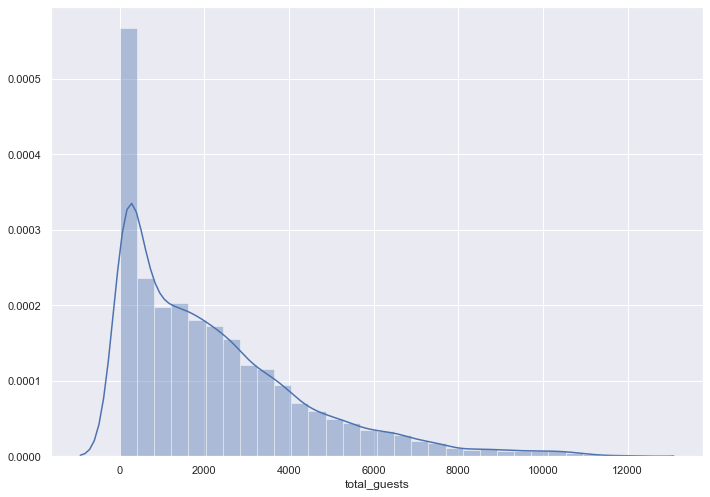

In [3]:
#Phase 3: Data Exploration
data_ready.isnull().sum()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(data_ready['total_guests'], bins=30)
plt.show()

'\nObservations from heatmap:\n1. Feels-Like-Temp is highly correlated to temperature\n-Ignore one of the variables from the model inputs is possible\n2. Temperature and total guests are moderately correlated (~0.4)\n-Higher the temperature more people will commute to go home\n3. Highest number of users between 3-7pm (~0.47)\n-Going home time\n4. Clear and cloudy variables are highly negatively correlated\n-Cloudy or clear.\n5. Interestingly no strong correlation on the users in the days of the week!\n'

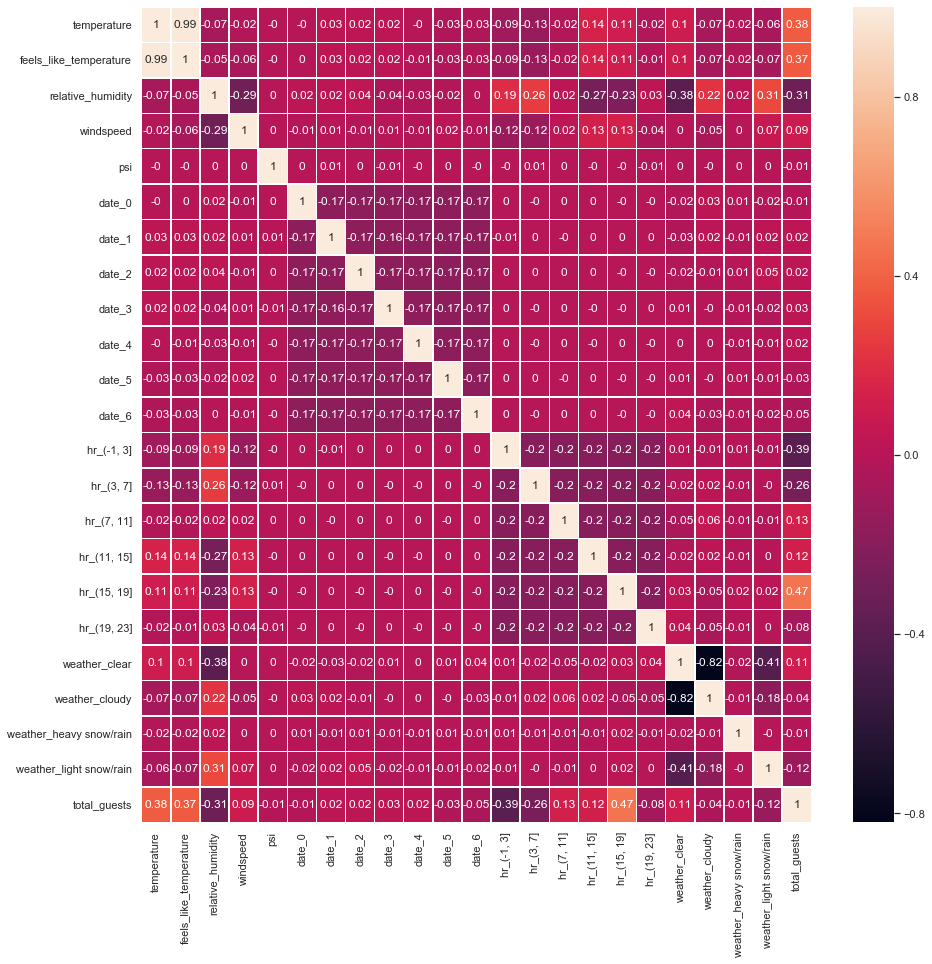

In [4]:
#Phase 3: Data Exploration
correlation_matrix = data_ready.corr().round(2)
# annot = True to print the values inside the square
plt.figure(figsize=(15,15))
sns.heatmap(data=correlation_matrix, annot=True,linewidth=0.5)

"""
Observations from heatmap:
1. Feels-Like-Temp is highly correlated to temperature
-Ignore one of the variables from the model inputs is possible
2. Temperature and total guests are moderately correlated (~0.4)
-Higher the temperature more people will commute to go home
3. Highest number of users between 3-7pm (~0.47)
-Going home time
4. Clear and cloudy variables are highly negatively correlated
-Cloudy or clear.
5. Interestingly no strong correlation on the users in the days of the week!
"""

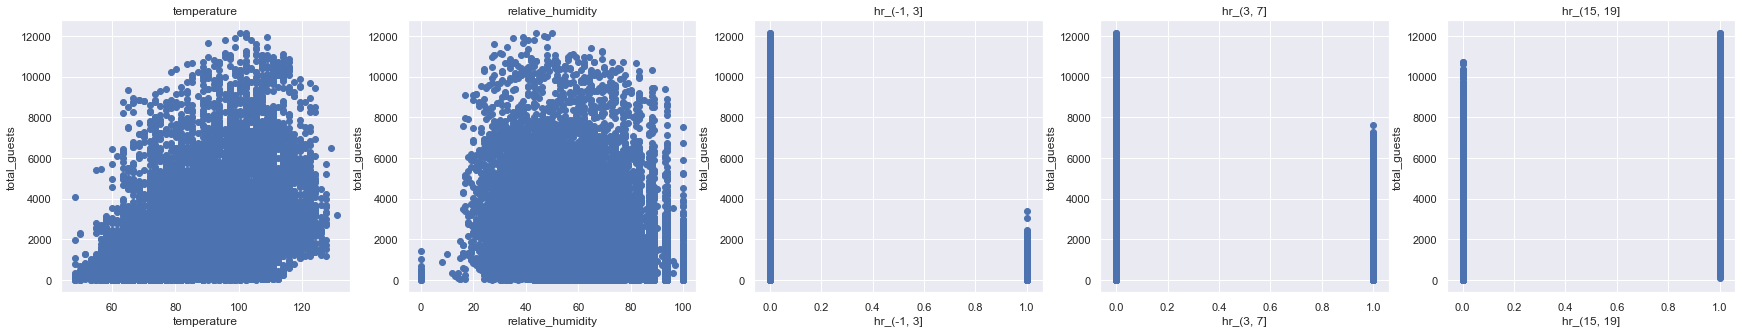

In [5]:
#Phase 3: Data Exploration
plt.figure(figsize=(30, 5))

features = ['temperature', 'relative_humidity','hr_(-1, 3]','hr_(3, 7]','hr_(15, 19]']
target = data_ready['total_guests']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = data_ready[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('total_guests')

In [6]:
X = pd.DataFrame(np.c_[data_ready['temperature'], data_ready['relative_humidity'],data_ready['hr_(-1, 3]'],data_ready['hr_(3, 7]'],data_ready['hr_(15, 19]']], columns = features)
Y = target

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5) #20% test; cross validation set
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score #Medium missing this r2_score

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
print ("RMSE:",rmse)
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")
print("Model Intercept:",lin_model.intercept_)
print("Model Coefficients:",lin_model.coef_)

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)

rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

(14366, 5)
(3592, 5)
(14366,)
(3592,)
RMSE: 1594.774880950042
The model performance for training set
--------------------------------------
RMSE is 1594.774880950042
R2 score is 0.45661035575420295


Model Intercept: -128.92638660603052
Model Coefficients: [   37.03520113   -11.21093811 -1870.28946944 -1134.07806884
  1804.88213449]
The model performance for testing set
--------------------------------------
RMSE is 1584.5229039258256
R2 score is 0.4584007100426547


In [7]:
X = X
Y = target

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5) #20% test; cross validation set
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 42)
regressor.fit(X_train, Y_train)
y_test_predict = regressor.predict(X_test)

# evaluating the model on test dataset
rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
r2_test = r2_score(Y_test, y_test_predict)

print("The model performance for the test set")
print("-------------------------------------------")
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

(14366, 5)
(3592, 5)
(14366,)
(3592,)
The model performance for the test set
-------------------------------------------
RMSE of test set is 1551.519527843614
R2 score of test set is 0.4807272458204467


[-3.6865990763024215e-05]
[-3.6865990763024215e-05, 0.4584007100426547]
[-3.6865990763024215e-05, 0.4584007100426547, 0.5044374402197603]
[-3.6865990763024215e-05, 0.4584007100426547, 0.5044374402197603, 0.5175779134398548]
[-3.6865990763024215e-05, 0.4584007100426547, 0.5044374402197603, 0.5175779134398548, 0.519378719207759]
[-3.6865990763024215e-05, 0.4584007100426547, 0.5044374402197603, 0.5175779134398548, 0.519378719207759, 0.5194793126893444]
[-3.6865990763024215e-05, 0.4584007100426547, 0.5044374402197603, 0.5175779134398548, 0.519378719207759, 0.5194793126893444, 0.5194701900629447]
[-3.6865990763024215e-05, 0.4584007100426547, 0.5044374402197603, 0.5175779134398548, 0.519378719207759, 0.5194793126893444, 0.5194701900629447, 0.5192859977459832]
[-3.6865990763024215e-05, 0.4584007100426547, 0.5044374402197603, 0.5175779134398548, 0.519378719207759, 0.5194793126893444, 0.5194701900629447, 0.5192859977459832, 0.5177312470132583]
[-3.6865990763024215e-05, 0.4584007100426547, 0.504

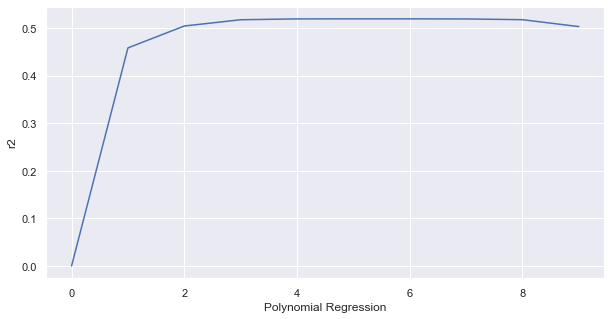

The model performance for the training set
-------------------------------------------
RMSE of training set is 1502.3880549148635
R2 score of training set is 0.517744900842592


The model performance for the test set
-------------------------------------------
RMSE of test set is 1492.6602798678557
R2 score of test set is 0.519378719207759


In [17]:
def create_polynomial_regression_model(degree):
  "Creates a polynomial regression model for the given degree"
  
  poly_features = PolynomialFeatures(degree=degree)
  
  # transforms the existing features to higher degree features.
  X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, Y_train)
  
  # predicting on training data-set
  y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # evaluating the model on training dataset
  rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
  r2_train = r2_score(Y_train, y_train_predicted)
  
  # evaluating the model on test dataset
  rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
  r2_test = r2_score(Y_test, y_test_predict)
  
  return [rmse_train,r2_train,r2_test,rmse_test,r2_test]
    

r2_list = []
for i in range(10):
    r2_value=create_polynomial_regression_model(i)[2]
    r2_list.append(r2_value)
    print(r2_list)
    
plt.figure(figsize=(10, 5))
plt.plot(r2_list)
plt.ylabel('r2')
plt.xlabel('Polynomial Regression')
plt.show()
          
[rmse_train,r2_train,r2_test,rmse_test,r2_test]=create_polynomial_regression_model(4)
print("The model performance for the training set")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))
  
print("\n")
  
print("The model performance for the test set")
print("-------------------------------------------")
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))
    

In [18]:
#Comments:
#1. Despite all the regression models that I've thorwn to the model, all R2 values are considered low
#2. Seems like the dataset didn't capture sufficient enough features to achieve high R2 value
#3. Recommended model to use is the one with highest R2 score Polynomial Regression (4).